In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.datasets import load_files
import pickle
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from dmba import regressionSummary, classificationSummary
from sklearn import metrics
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, accuracy_score, precision_score, confusion_matrix


Labelling used is as follows

Positive = 1

Negative = 2

Neutral = 0

In [58]:
flipkarts = []

def get_soup(url):
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    return soup

def get_reviews(soup):
    flipkarts_a = []
    containers = soup.findAll("div", {'class': 'col _2wzgFH K0kLPL'})
    for i in containers:
        
        try:
            try:
                try:
                
                    ratings_f = i.find('div',{'class':'_3LWZlK _1BLPMq'}).text
                    ratings_f = ratings_f.replace('[','').replace(']','').replace(',','').strip()
                except:
                    ratings_f = i.find('div',{'class':'_3LWZlK _1rdVr6 _1BLPMq'}).text
                    ratings_f = ratings_f.replace('[','').replace(']','').replace(',','').strip()

            except:
                ratings_f = i.find('div',{'class':'_3LWZlK _32lA32 _1BLPMq'}).text
                ratings_f = ratings_f.replace('[','').replace(']','').replace(',','').strip()     
        except:
            ratings_f = ''
        
        re = {
        'rating' : ratings_f,
        'review' : i.find('div',{'class':'t-ZTKy'}).text,
        }
        flipkarts_a.append(re)
    return flipkarts_a

for x in range(20,680):
    url = 'https://www.flipkart.com/redmi-note-5-blue-32-gb/product-reviews/itmf3qsthbjgxsks?pid=MOBF28FTCDFR7VYZ&lid=LSTMOBF28FTCDFR7VYZKBOSXC&aid=overall&certifiedBuyer=false&sortOrder=NEGATIVE_FIRST&page='+str(x)
    soup = get_soup(url)
    #print(f'Getting page: {x}')
    
    flipkarts = flipkarts + get_reviews(soup)
   # print(len(flipkarts))
    if not soup.find('li', {'class': 'a-disabled a-last'}):
        pass
    else:
        break
df = pd.DataFrame(flipkarts)
print(df.shape)
df.head()

(6600, 2)


,rating,review
0,1,please don't buy this phone! this have a drawb...
1,1,bad 👎😈READ MORE
2,1,This is my 2nd Redmi fone and writing this rev...
3,1,very bad product don't buyREAD MORE
4,1,"Worst Experience with MI, I have been using it..."


In [34]:
df.to_csv('reviews.csv')

In [2]:
df_new = pd.read_csv('reviews.csv')
df_new.tail()

,Unnamed: 0,rating,review
6585,6585,4,over all good productREAD MORE
6586,6586,4,It is really awesome.READ MORE
6587,6587,4,"well display,READ MORE"
6588,6588,4,delivery is good but product are badREAD MORE
6589,6589,4,very good productREAD MORE


In [3]:
#df_new = dn
for index in df_new.index:
    if df_new.loc[index,'rating']==5:
        df_new.loc[index,'rating'] = 1
    elif df_new.loc[index,'rating']==4:
        df_new.loc[index,'rating'] = 1
    elif df_new.loc[index,'rating']==3:
        df_new.loc[index,'rating'] = 0
    elif df_new.loc[index,'rating']==2:
        df_new.loc[index,'rating'] = 2
    elif df_new.loc[index,'rating']==1:
        df_new.loc[index,'rating'] = 2
    else:
        df_new.loc[index,'rating'] = 2

In [4]:
df_new.groupby('rating').count()

,Unnamed: 0,review
rating,,
0,2183,2183
1,2185,2185
2,2222,2222


In [31]:
df_new.head()

,Unnamed: 0,rating,review
0,0,2.0,nothing new as compared to note4....mi could p...
1,1,2.0,"Genuine comment--Back Camera WORST, little bul..."
2,2,2.0,Below average phone from Xiomi.. within 2 mont...
3,3,2.0,very bad experience after one year getting han...
4,4,2.0,i am bought the Redmi note 5 on may 22 used i...


In [5]:
y = df_new['rating']
y=y.astype('int')
X = df_new['review']

In [6]:
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

sw = set(stopwords.words('english'))
sw.update(['.',';'])
ps = PorterStemmer()
ls = WordNetLemmatizer()
def clean_lem(revs):
    out = []
    for r in revs:
        ts = r.split()
        nts = [w.lower() for w in ts] #lower case words
        nts = [w for w in nts if w not in sw] #stop word removal
        nts = [ls.lemmatize(w) for w in nts] #apply lemmatization
        res = ' '.join(nts)
        out.append(res)
    return out
#using lemmatization in place of stemming
X_lem = clean_lem(X)

In [151]:
X

0       please don't buy this phone! this have a drawb...
1                                         bad 👎😈READ MORE
2       This is my 2nd Redmi fone and writing this rev...
3                     very bad product don't buyREAD MORE
4       Worst Experience with MI, I have been using it...
                              ...                        
6585                       over all good productREAD MORE
6586                       It is really awesome.READ MORE
6587                               well display,READ MORE
6588        delivery is good but product are badREAD MORE
6589                           very good productREAD MORE
Name: review, Length: 6590, dtype: object

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X_new = vectorizer.fit_transform(X_lem).toarray()
from sklearn.feature_extraction.text import TfidfTransformer
tfidfconverter = TfidfTransformer()
X_v = tfidfconverter.fit_transform(X_new).toarray()

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_v, y, test_size=0.3, random_state=0)

In [9]:
import sklearn as sklearn

scorer = sklearn.metrics.make_scorer(sklearn.metrics.f1_score, average = 'weighted')

#grid based decision RANDOM FOREST
grid_rf = RandomForestClassifier(n_jobs = -1)
grid_values_rf = {'n_estimators':[300],'criterion':['entropy'],'max_depth':[10]
                 ,'max_features':['auto'],'class_weight':['balanced'],'random_state':[0]}
grid_clf_acc_rf = GridSearchCV(grid_rf, param_grid = grid_values_rf,scoring = scorer)
grid_clf_acc_rf.fit(X_train, y_train)

#Predict values based on new parameters
y_pred_acc_rf = grid_clf_acc_rf.predict(X_test)
print(grid_clf_acc_rf.best_params_)

print(confusion_matrix(y_test,y_pred_acc_rf))
print(classification_report(y_test,y_pred_acc_rf))
print(accuracy_score(y_test, y_pred_acc_rf))
from sklearn.metrics import f1_score
f1_score(y_test, y_pred_acc_rf,average = 'weighted')
print(grid_clf_acc_rf.best_score_)



{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 300, 'random_state': 0}
[[294 220 151]
 [200 391  62]
 [179  80 400]]
              precision    recall  f1-score   support

           0       0.44      0.44      0.44       665
           1       0.57      0.60      0.58       653
           2       0.65      0.61      0.63       659

    accuracy                           0.55      1977
   macro avg       0.55      0.55      0.55      1977
weighted avg       0.55      0.55      0.55      1977

0.548811330298432
0.5350076659576228


In [10]:
y_pred_acc_rf

array([0, 2, 2, ..., 1, 2, 2])

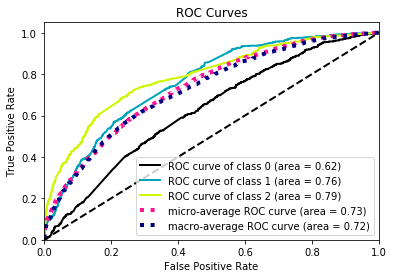

In [155]:
rf_prob = grid_clf_acc_rf.predict_proba(X_test)
import scikitplot as skplt
skplt.metrics.plot_roc_curve(y_test, rf_prob)
plt.show()

In [157]:
grid_dt = DecisionTreeClassifier()
#sk_dt = StratifiedKFold(n_splits=5)
scorer = sklearn.metrics.make_scorer(sklearn.metrics.f1_score, average = 'weighted')

grid_values_dt = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8],'splitter':['best','random'],'min_samples_split':[2],
                  'min_samples_leaf':[1]
              ,'class_weight':['balanced'], 'max_features':['auto','sqrt','log2'],'random_state':[3]}
grid_clf_acc_dt = GridSearchCV(grid_dt, param_grid = grid_values_dt,scoring = scorer)
grid_clf_acc_dt.fit(X_train, y_train)

#Predict values based on new parameters
y_pred_acc_dt = grid_clf_acc_dt.predict(X_test)
print(grid_clf_acc_dt.best_params_)

print(confusion_matrix(y_test,y_pred_acc_dt))
print(classification_report(y_test,y_pred_acc_dt))
print(accuracy_score(y_test, y_pred_acc_dt))
from sklearn.metrics import f1_score
f1_score(y_test, y_pred_acc_dt,average = 'weighted')
print(grid_clf_acc_dt.best_score_)


{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 3, 'splitter': 'best'}
[[  5 164 496]
 [  4 225 424]
 [  6  91 562]]
              precision    recall  f1-score   support

           0       0.33      0.01      0.01       665
           1       0.47      0.34      0.40       653
           2       0.38      0.85      0.52       659

    accuracy                           0.40      1977
   macro avg       0.39      0.40      0.31      1977
weighted avg       0.39      0.40      0.31      1977

0.4006069802731411
0.31235222833376974


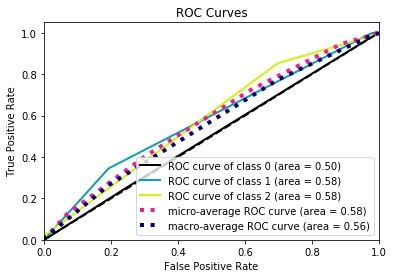

In [158]:
rf_prob = grid_clf_acc_dt.predict_proba(X_test)
import scikitplot as skplt
skplt.metrics.plot_roc_curve(y_test, rf_prob)
plt.show()

In [159]:
import lightgbm as lgb


d_train = lgb.Dataset(X_train, label=y_train)
params = {}
params={}
params['learning_rate']=0.05
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='multiclass' #Multi-class target feature
params['metric']='multi_logloss' #metric for multi-class
params['max_depth']=5
params['num_class']=3 #no.of unique values in the target class not inclusive of the end value
clf = lgb.train(params, d_train, 100)
y_pred_1=clf.predict(X_test)
y_pred_1

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5990
[LightGBM] [Info] Number of data points in the train set: 4613, number of used features: 236
[LightGBM] [Info] Start training from score -1.111485
[LightGBM] [Info] Start training from score -1.102304
[LightGBM] [Info] Start training from score -1.082271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


array([[0.37818984, 0.38141391, 0.24039625],
       [0.24243932, 0.0923121 , 0.66524858],
       [0.21269952, 0.2789239 , 0.50837658],
       ...,
       [0.39233116, 0.46222002, 0.14544882],
       [0.32114425, 0.25703651, 0.42181924],
       [0.32605743, 0.26217081, 0.41177176]])

In [160]:
y_pred_1=clf.predict(X_test)
y_pred_1
y_pred_1 = [np.argmax(line) for line in y_pred_1]
precision_score(y_pred_1,y_test,average=None).mean()

0.5336494081760624

In [164]:
acc_lgbm = accuracy_score(y_test,y_pred_1)
print('Overall accuracy of Light GBM model:', acc_lgbm)

Overall accuracy of Light GBM model: 0.5326251896813353


In [167]:
print(accuracy_score(y_test, y_pred_1))
print(confusion_matrix(y_test,y_pred_1))
f1_score(y_test, y_pred_1,average = 'weighted')


0.5326251896813353
[[187 279 199]
 [132 404 117]
 [ 92 105 462]]


0.5164570226888701